# Data Cleaning procedure
When a lot of data is collected manually, there will always be some errors.  However, with replicated time repeated measurements, errant data points are easily identified, removed and backfilled with estimated values.  This document describes and implements the process of cleaning the Neutron probe data collected for this trial.

In [66]:
#Bring in python libaries
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
%matplotlib inline

In [67]:
#Read in data
AllData=pd.read_csv('.\RawDataFiles\AllNeutronProbeData.csv', #specify file path for data to read in
                    parse_dates=True, #tell the function to parse date columns to datetime formats
                    dayfirst=True, #tell the function that the day is before the year in the data i.e format='%d/%m/%Y %H:%M'
                    index_col = 0, #Use the first column, which is Date, as an index
                    na_values = 'NAN')

#Bring in index data
AllDataIndex=pd.read_csv('.\IndexFiles\\NeutronProbeIndex.csv',
                         index_col = 0)
AllDataIndex.Block = [str(x) for x in AllDataIndex.Block]
#Apply indexes to data
AllDataTransposed = AllData.transpose()
AllDataIndexed = pd.concat([AllDataIndex,AllDataTransposed], axis=1,sort=True)
AllDataIndexed.index.name='ColumnHeader'
AllDataIndexed.set_index(['Depth','Species','Irrigation','Block'], 
                        append=False, inplace=True)
AllDataIndexed.sort_index(inplace=True)
AllDataIndexed.sort_index(inplace=True,axis=1)
Data=AllDataIndexed.transpose()
Data.index = pd.to_datetime(Data.index)  ## for some reason the concat function changes the data type on the date indes so need to change it back

In [68]:
IndexFrame=pd.read_csv('.\\IndexFiles\\NeutronProbeIndex.csv')

# View Data and remove missing value negatives

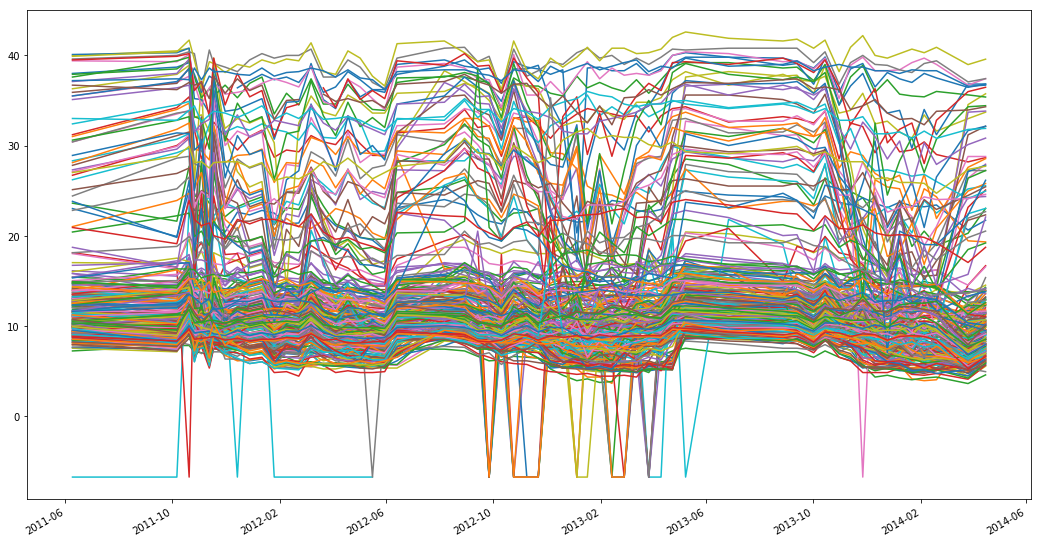

In [69]:
Data.plot(figsize=(18,10),legend=False)

On some occasions negative values are recored by the instrument showing non measurements.  The data points need to be set to Nan.  
After we do that the data looks like this

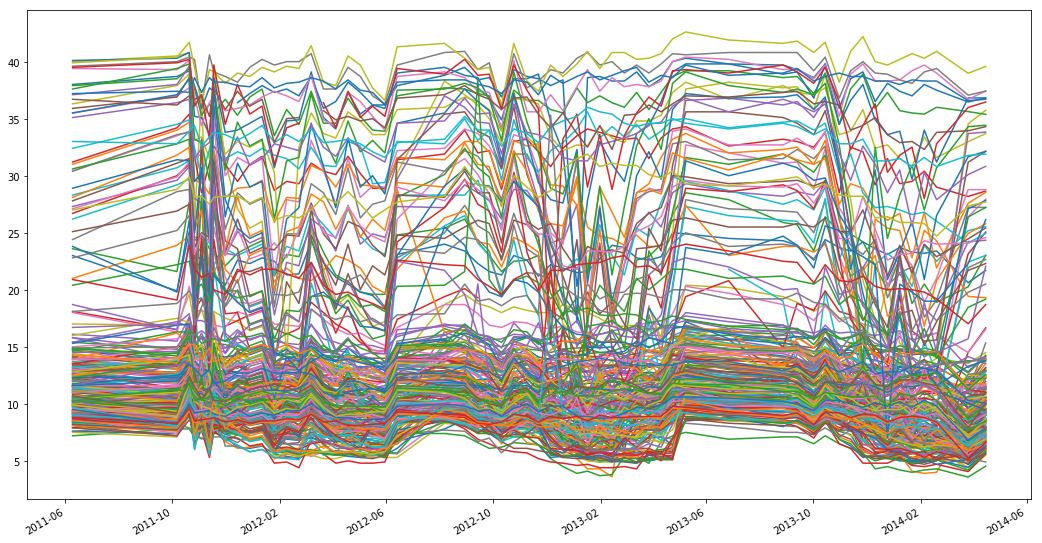

In [70]:
#Set low values where sensors where not working to nan
Data.where(Data>2, np.nan,inplace=True)

#Graph dataframe to check all is good
Data.plot(figsize=(18,10),legend=False)

That gets rid of errant zeros from the data set.  Now we graph data for individual measurement positions over time to check patterns

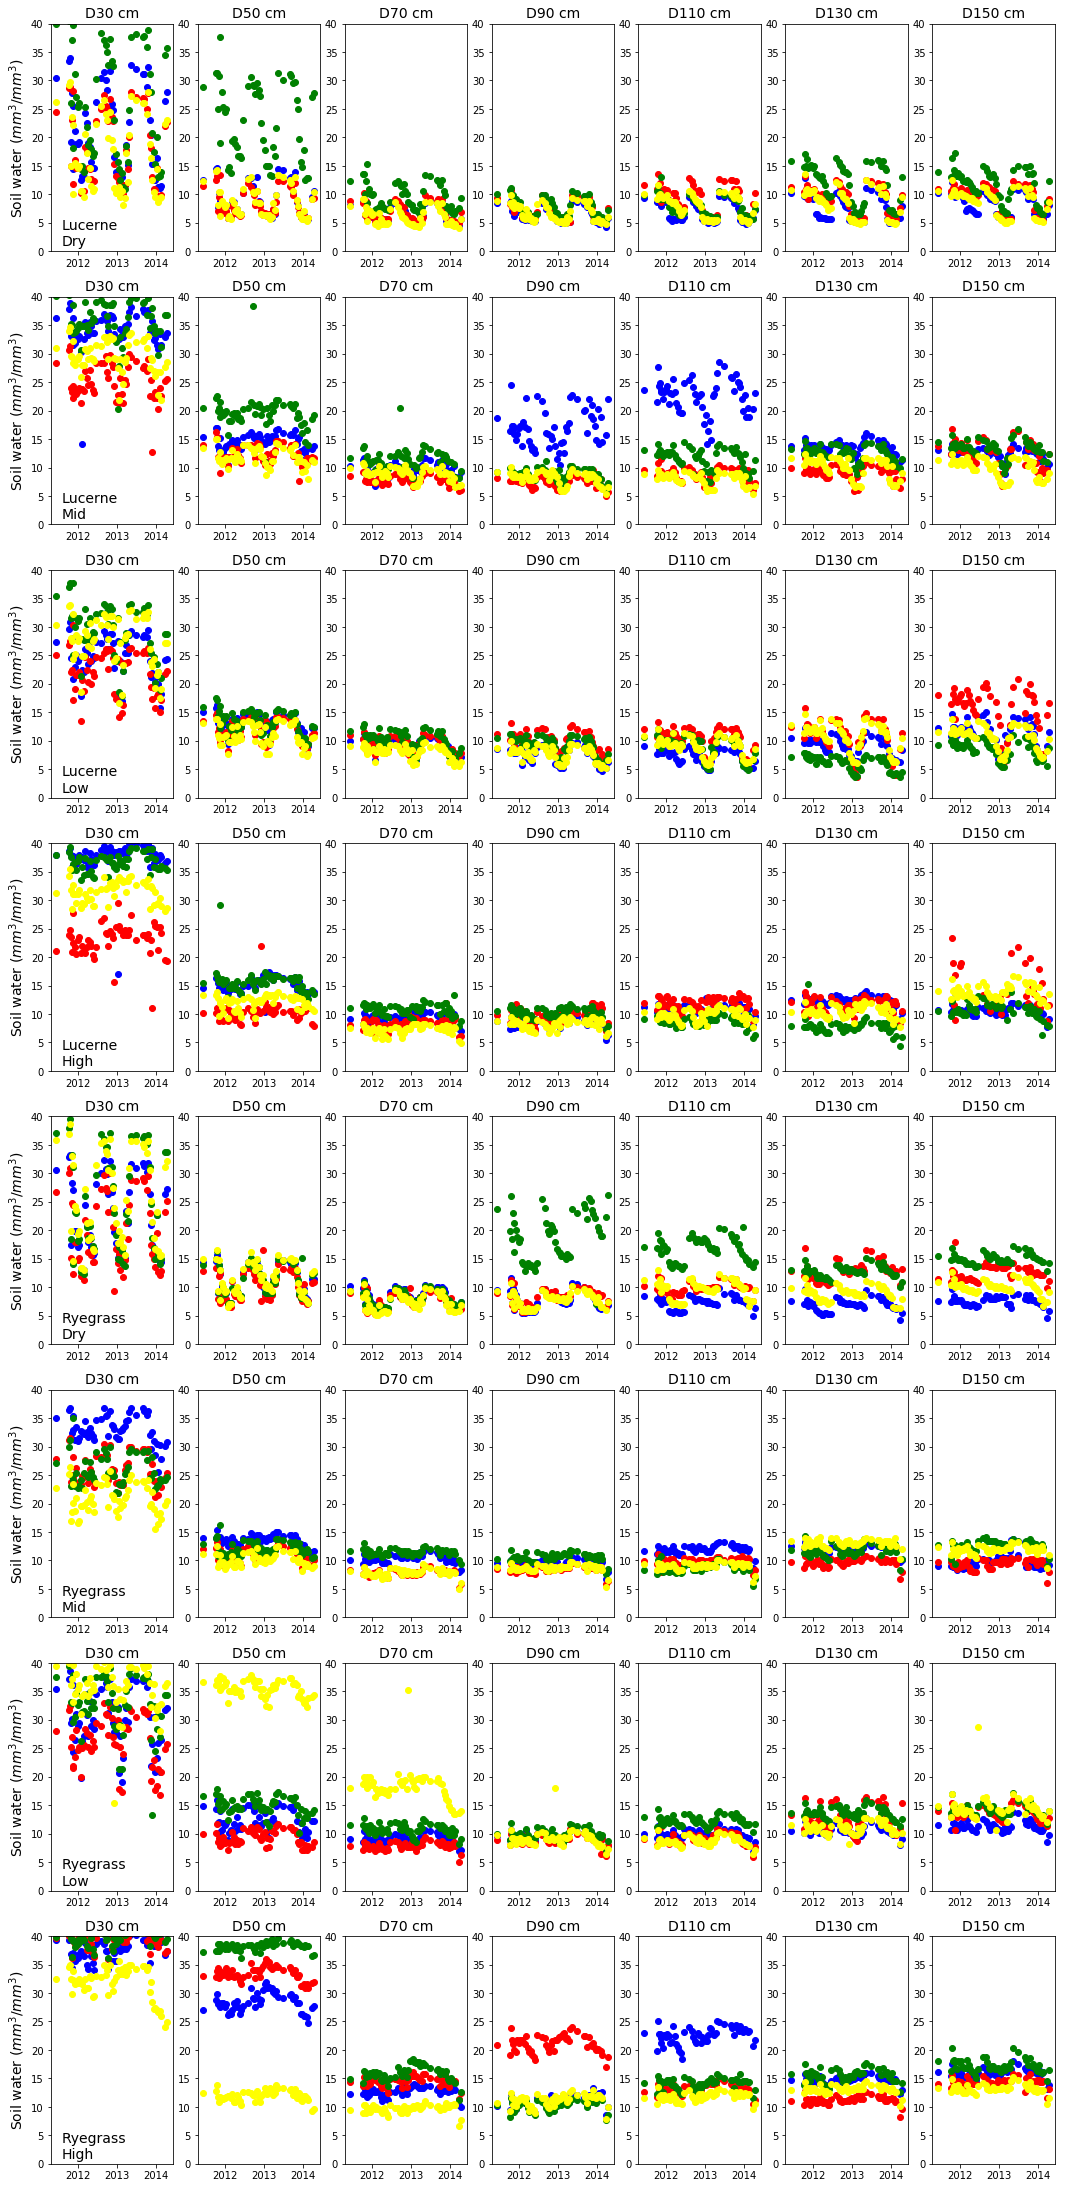

In [71]:
#Create a figure object
Fig = plt.figure(figsize=(18, 160))
Crops = ['Lucerne','Ryegrass']
Irrigs = ['Dry', 'Mid', 'Low', 'High']
Depths = ['D30', 'D50', 'D70', 'D90','D110', 'D130', 'D150']
colors =['blue','red','green','yellow']

#Function call to populate figure with subplots
def MakePlot(Position, SeriesValues, Plot,Col):
    Fig.add_subplot(32,7,Position)
    plt.title(Plot, fontsize=14);
    plt.plot(Data.index,SeriesValues, 'o',color=Col);
    plt.xticks(['2012-01-01','2013-01-01','2014-01-01'])
    plt.ylim(0,40)
    return;
    
#For loop that steps through each series (a series is a time series of measurements for a given depth in a given experimental plot) 
#and produces a sub plot of the time series of VWC data
Position = 1
for Cro in Crops:
    for Irr in Irrigs:
        for Dep in Depths:
            colPos = 0
            SeriesValues = Data.loc[:,(Dep,Cro,Irr,'1')]
            MakePlot(Position, SeriesValues, Dep+' cm',colors[colPos])
            if Dep == 'D30':
                plt.text('2011-08-01',1,Cro+'\n'+Irr,fontsize=14)
                plt.ylabel(r'Soil water ($mm^3/mm^3$)', fontsize=14)
            Position += 1;
            for Blo in ['2','3','4']:
                colPos+=1
                block = Data.loc[:,(Dep,Cro,Irr,Blo)]
                plt.plot(block.index,block,'o',color = colors[colPos])
                
    

There are some points that are clear outliers which need to be removed.  For example, below we have graph the 30 cm depth measured data for the two per week lucerne treatment.  B1 Just after December 2012 and B2 just before December 2013 are not zero values but are clearly errant as they don't fit with the remainder of the time data for that block and the sudden drop is anomalous compared with the other reps measured at this time.  These outliers will need to be removed

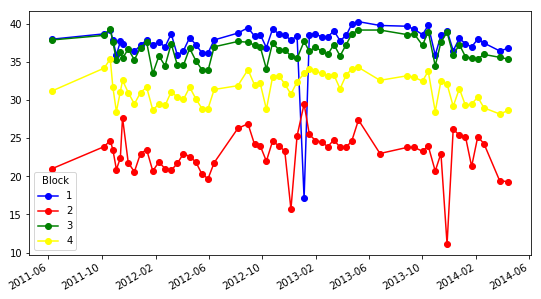

In [72]:
Data.D30.Lucerne.High.plot(marker='o',color=colors,figsize=(9,5))

# Identify and remove outliers

We have removed all the values that were obviously wrong because they were negative.  However there are still errant numbers within in the normal range of data because of opperator or instrument error.  These can be identified by looking at values relative to the equivelent values in the same treatment and measurement depth.

First we calculate treatment means

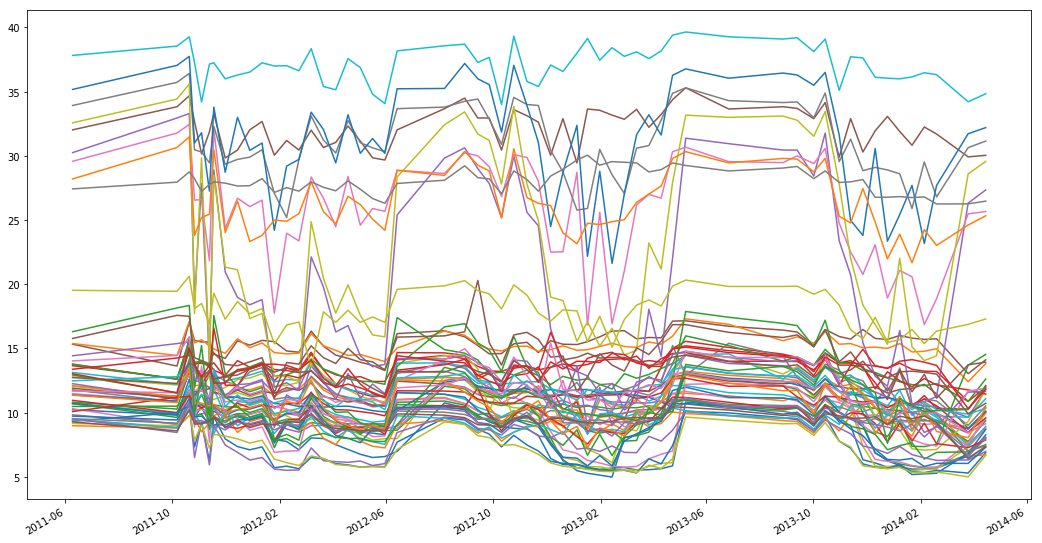

In [73]:
AllTreatmentMeans= Data.groupby(level=['Depth','Species','Irrigation'],axis=1).mean()
AllTreatmentMeans.plot(figsize=(18,10), legend = False)

Then we calcualte the offset for each plot relative to their treatment mean

In [74]:
#Set up empty dataframe with the same index and column structure as the data object
OffSets = pd.DataFrame(index = Data.index, columns = Data.columns)  

#Step through each series (a series is a time series of measurements for a given depth in a given experimental plot) 
#and produces a sub plot of the time series of VWC data
for X in range (0,224): 
    #Set index values for each series of measurements
    Depth = AllDataIndex.iloc[X,0]
    Crop = AllDataIndex.iloc[X,1]
    Irrigation = AllDataIndex.iloc[X,2]
    Block = AllDataIndex.iloc[X,3]
    #Create an object containing the time series of mean values for the treatment and depth that the current series belongs to.
    TreatmentMeans = AllTreatmentMeans.loc[:,(Depth,Crop,Irrigation)]
    #Create an object containing the time series of measurements for the plot and measurement depth currently under consideration 
    SeriesValues = Data.loc[:,(Depth,Crop,Irrigation,Block)]
    OffSets.loc[:,(Depth,Crop,Irrigation,Block)] = SeriesValues - TreatmentMeans 

Plotting all offset data in the figure below shows some spikes which are errant data that need to be removed

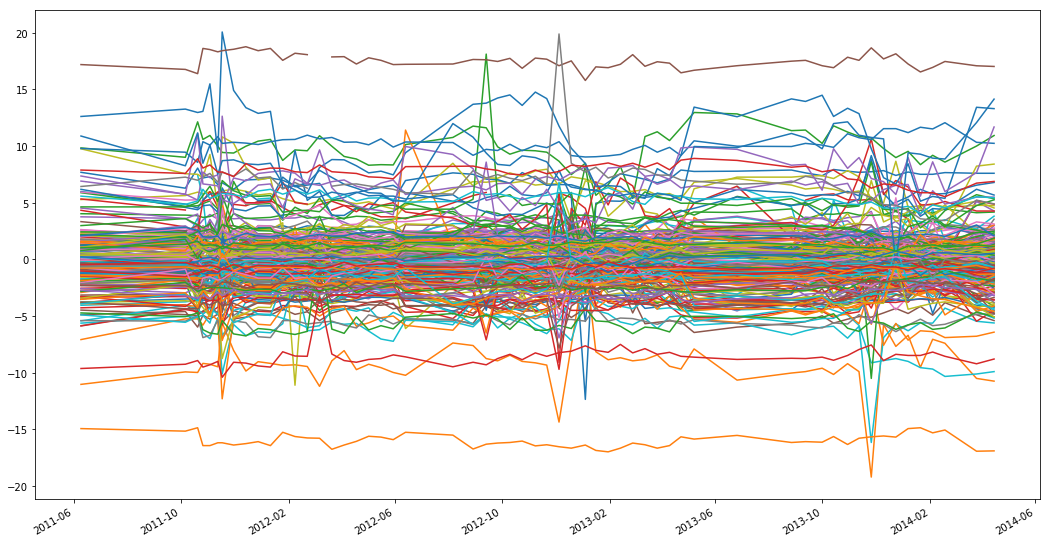

In [75]:
OffSets.plot(figsize=(18,10), legend=False)

Identify outliers and create a dataframe that tags these

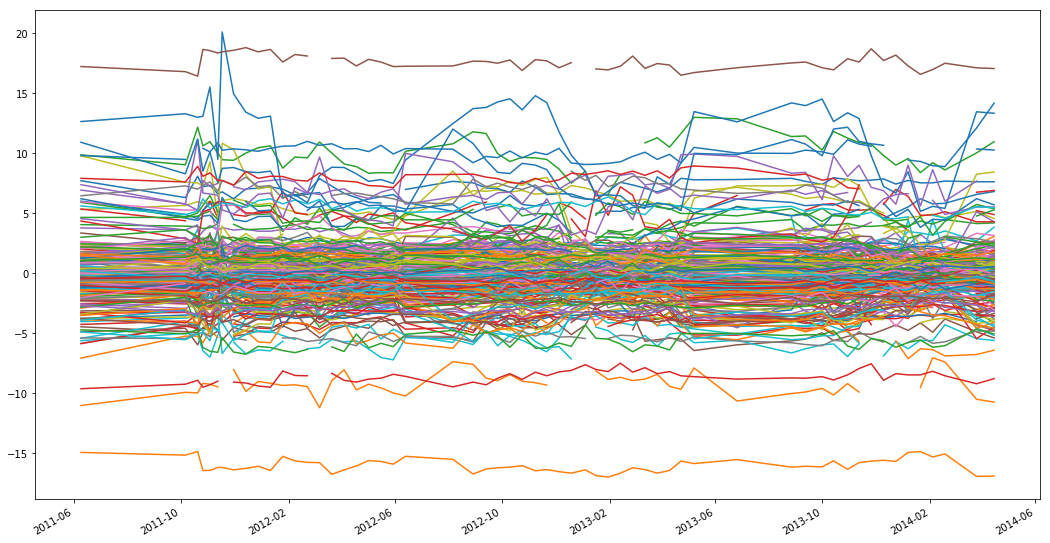

In [76]:
#Create DataFrame to hold identified outliers
OffSetsCleaned = pd.DataFrame(index = Data.index, columns = Data.columns)  

#Step through each series and identify outliers
for X in range (0,224):
    #Set up index data for current series
    Depth = AllDataIndex.iloc[X,0]
    Crop = AllDataIndex.iloc[X,1]
    Irrigation = AllDataIndex.iloc[X,2]
    Block = AllDataIndex.iloc[X,3]
    #Create an object containing the time series of measurements for the plot and measurement depth currently under consideration 
    SeriesOffSets = OffSets.loc[:,(Depth,Crop,Irrigation,Block)]
    #Calculate the median value for the current series of offsets
    SeriesMedian = SeriesOffSets.median()
    #Calculate the distance each data point is from the median for the current series
    DataDistance = np.abs(SeriesOffSets - SeriesMedian)
    #calculate the median data distance for the current series
    mdev = DataDistance.median()
    #Calculate how far each data point is from the median data distance
    s = DataDistance/mdev if mdev else 0
    #Add data into the OffSetsCleaned dataframe that is within s=4 (ie the values that are not outliers)
    #The outlier threshold of s>4 is arbitary
    OffSetsCleaned.loc[:,(Depth,Crop,Irrigation,Block)] = SeriesOffSets[s<3.5]
    
#Plot Offsets with outliers masked to chekc all looks OK
OffSetsCleaned.plot(figsize=(18,10), legend=False)

The spikes are all gone from the dataframe now we can use this to make a mask identifying which data points are legitimeate

In [77]:
#Make all legitimate offset data positive
OutLierMask = OffSetsCleaned.abs()
#Make outlier (which are currently nan) into -1
OutLierMask.fillna(-10, inplace = True)
#Make all Legitimate offset data ponits equal 1
OutLierMask.where(OutLierMask<0,1,inplace=True)
#Make all outlier (which are currently -1) into nan again
OutLierMask.where(OutLierMask>0,np.nan, inplace=True)
#so we have a data frame with 1s where data is legitimate and nan where there are outliers

Now use the outlier mask to make outlier Neutron Probe data nan and graph the data to check

In [78]:
#Multiply Data object (containing measurements legitimate and outliers) by OutlierMask (which has 1 for 
#legitimate values and nan for outliers) to create nan for outliers in Data object
Data = Data.multiply(OutLierMask)

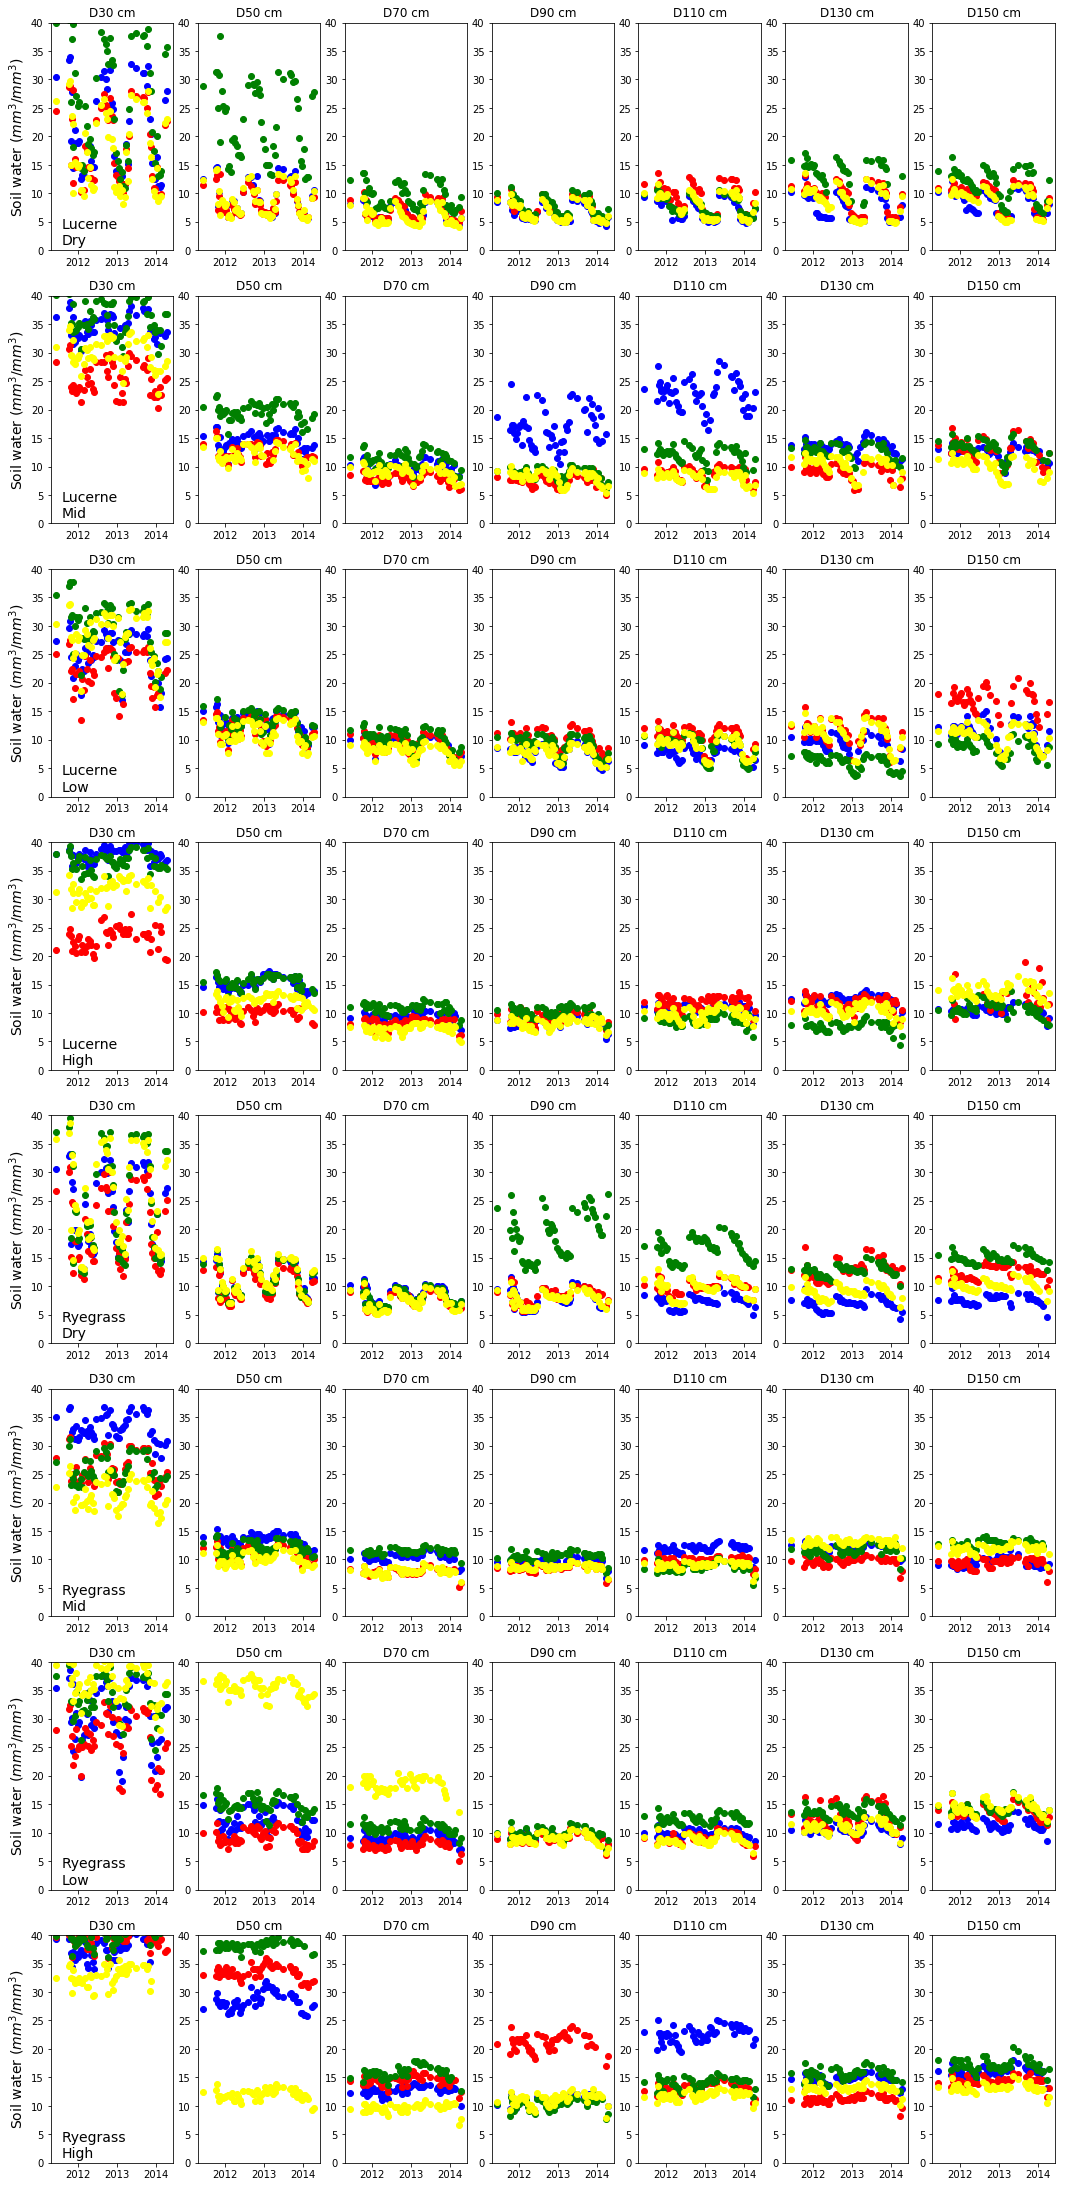

In [79]:
##create a graph to check outliers are gone
Fig = plt.figure(figsize=(18, 160))

#Function to add subplots onto figure
def MakePlot(Position, SeriesValues, Series,Col):
    Fig.add_subplot(32,7,Position)
    plt.title(Series, fontsize=12);
    plt.plot(Data.index,SeriesValues, 'o',color=Col);
    plt.xticks(['2012-01-01','2013-01-01','2014-01-01'])
    plt.ylim(0,40)
    return;

#For loop that steps through each series (a series is a time series of measurements for a given depth in a given experimental plot) 
#and produces a sub plot of the time series of VWC data
Position = 1
for Cro in Crops:
    for Irr in Irrigs:
        for Dep in Depths:
            colPos = 0
            SeriesValues = Data.loc[:,(Dep,Cro,Irr,'1')]
            MakePlot(Position, SeriesValues, Dep+' cm',colors[colPos])
            if Dep == 'D30':
                plt.text('2011-08-01',1,Cro+'\n'+Irr,fontsize=14)
                plt.ylabel(r'Soil water ($mm^3/mm^3$)', fontsize=14)
            Position += 1;
            for Blo in ['2','3','4']:
                colPos+=1
                block = Data.loc[:,(Dep,Cro,Irr,Blo)]
                plt.plot(block.index,block,'o',color = colors[colPos])

# Synthisise data to back fill gaps
Gaps in water data sets cause big problems.  A missing value from one depth in the profile means a profile water content can not be calculated and that means a water use calculation can not be made for the measurement period preceding.  However, missing values can be reliably estimated in time coarse replicated data.  Below we estimate values and use them to fill gaps so we have a complete data set.   

First graph offsets calculated for each plot against treatment mean water content to see if there is any systematic variation in offsets

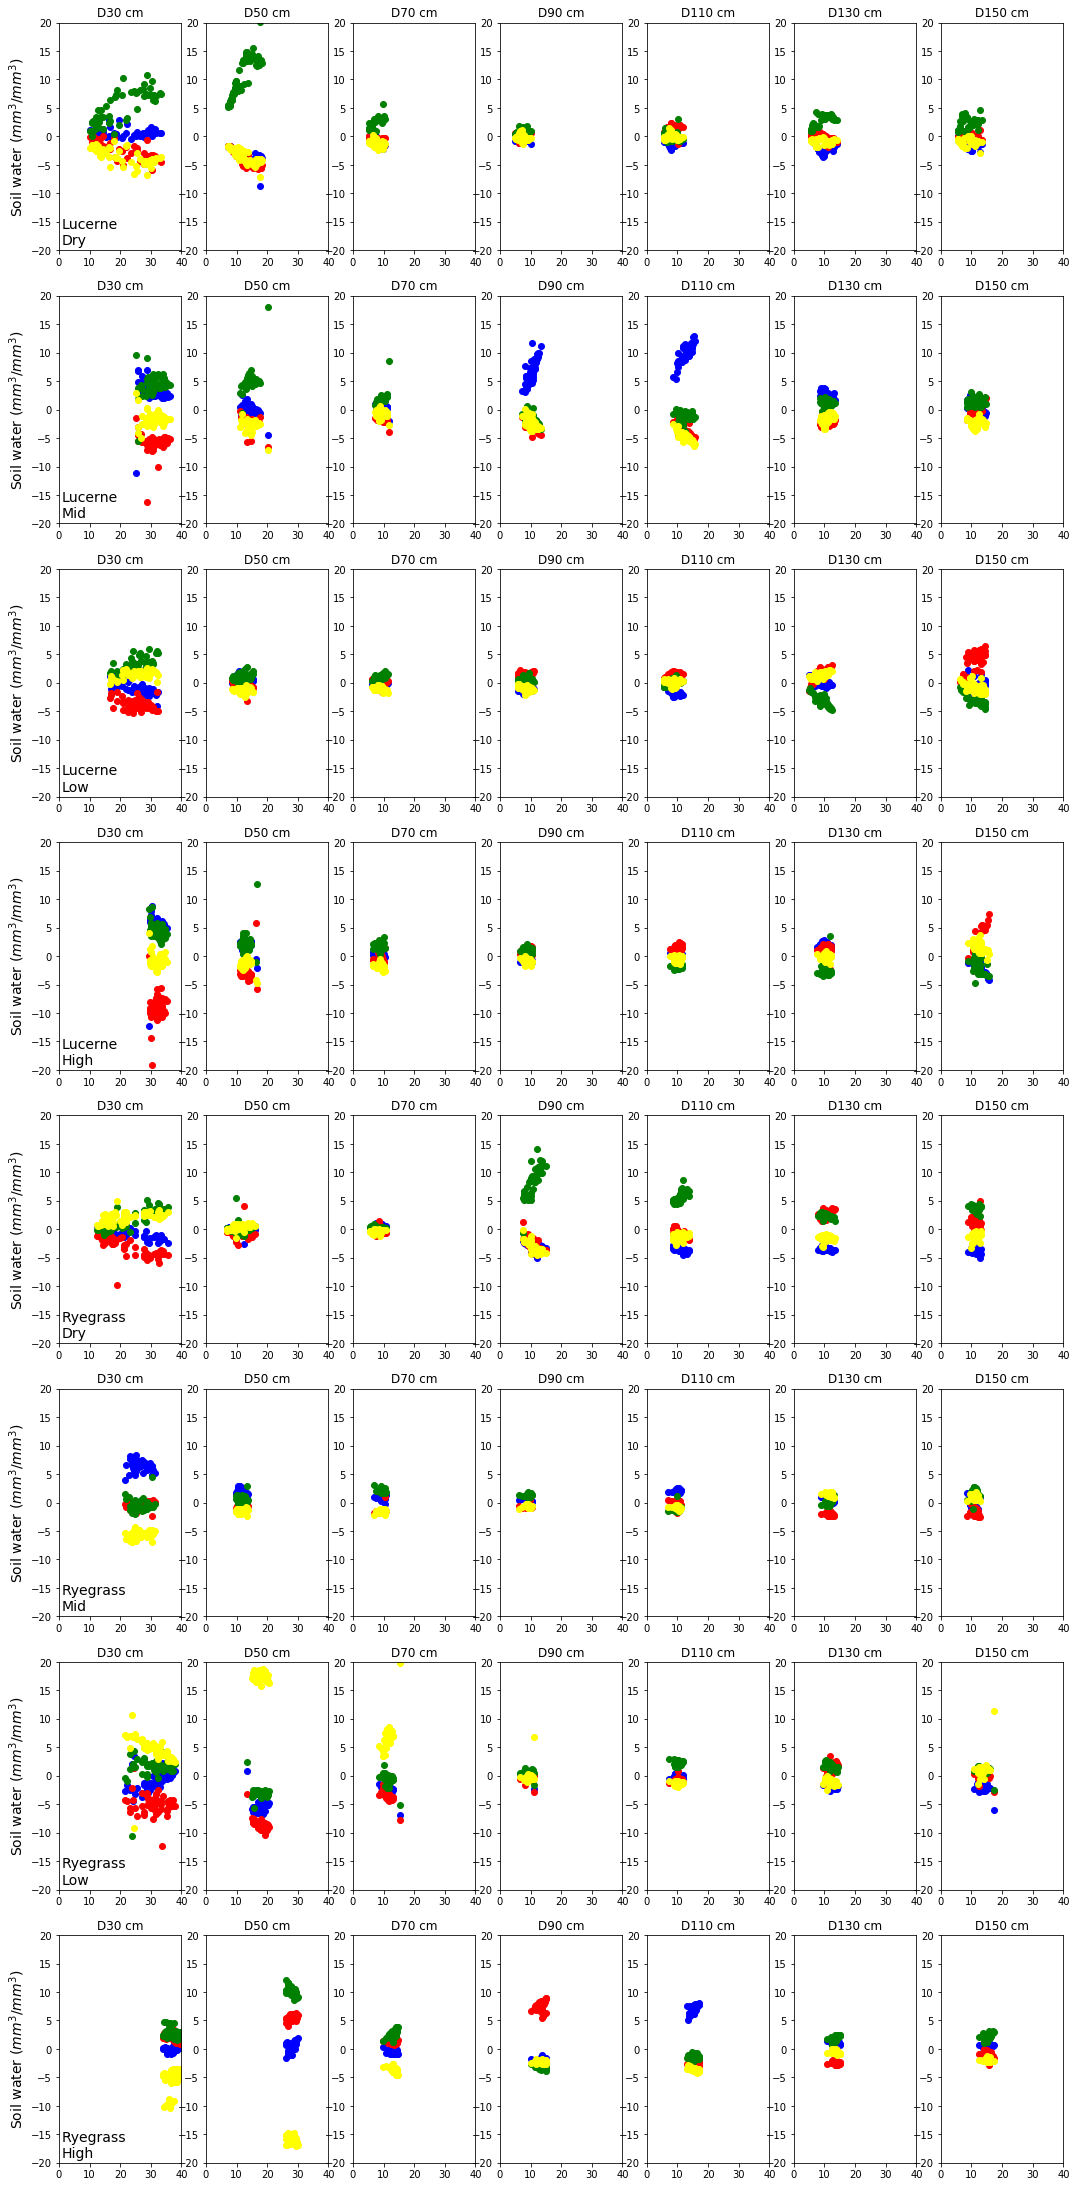

In [80]:
#create figure to add subplots onto
Fig = plt.figure(figsize=(18, 160))

#Function to add subplots onto figure
def MakePlot(Position, TreatmentMeans, SeriesOffSets, Series,Col):
    Fig.add_subplot(32,7,Position)
    plt.title(Series, fontsize=12);
    plt.plot(TreatmentMeans,SeriesOffSets, 'o', color=Col);
    plt.ylim(-20,20)
    plt.xlim(0,40)
    return;

#Step through each series and add sub plot onto figure
Position = 1
for Cro in Crops:
    for Irr in Irrigs:
        for Dep in Depths:
            colPos = 0
            #Create an object containing the time series of mean values for the treatment and depth that the current series belongs to.
            TreatmentMeans = AllTreatmentMeans.loc[:,(Dep,Cro,Irr)]
            SeriesOffSets = OffSets.loc[:,(Dep,Cro,Irr,'1')]
            MakePlot(Position, TreatmentMeans, SeriesOffSets, Dep+' cm',colors[colPos])
            if Dep == 'D30':
                plt.text(1,-19,Cro+'\n'+Irr,fontsize=14)
                plt.ylabel(r'Soil water ($mm^3/mm^3$)', fontsize=14)
            Position += 1;
            for Blo in ['2','3','4']:
                colPos +=1
                TreatmentMeans = AllTreatmentMeans.loc[:,(Dep,Cro,Irr)]
                SeriesOffSets = OffSets.loc[:,(Dep,Cro,Irr,Blo)]
                plt.plot(TreatmentMeans,SeriesOffSets, 'o',color = colors[colPos]);

There appears to be some systematic variation in offsets so we need a function to account for this.  We used a linear regression, estimating the offset for a plot as a function of the treatment mean volumetric water content.

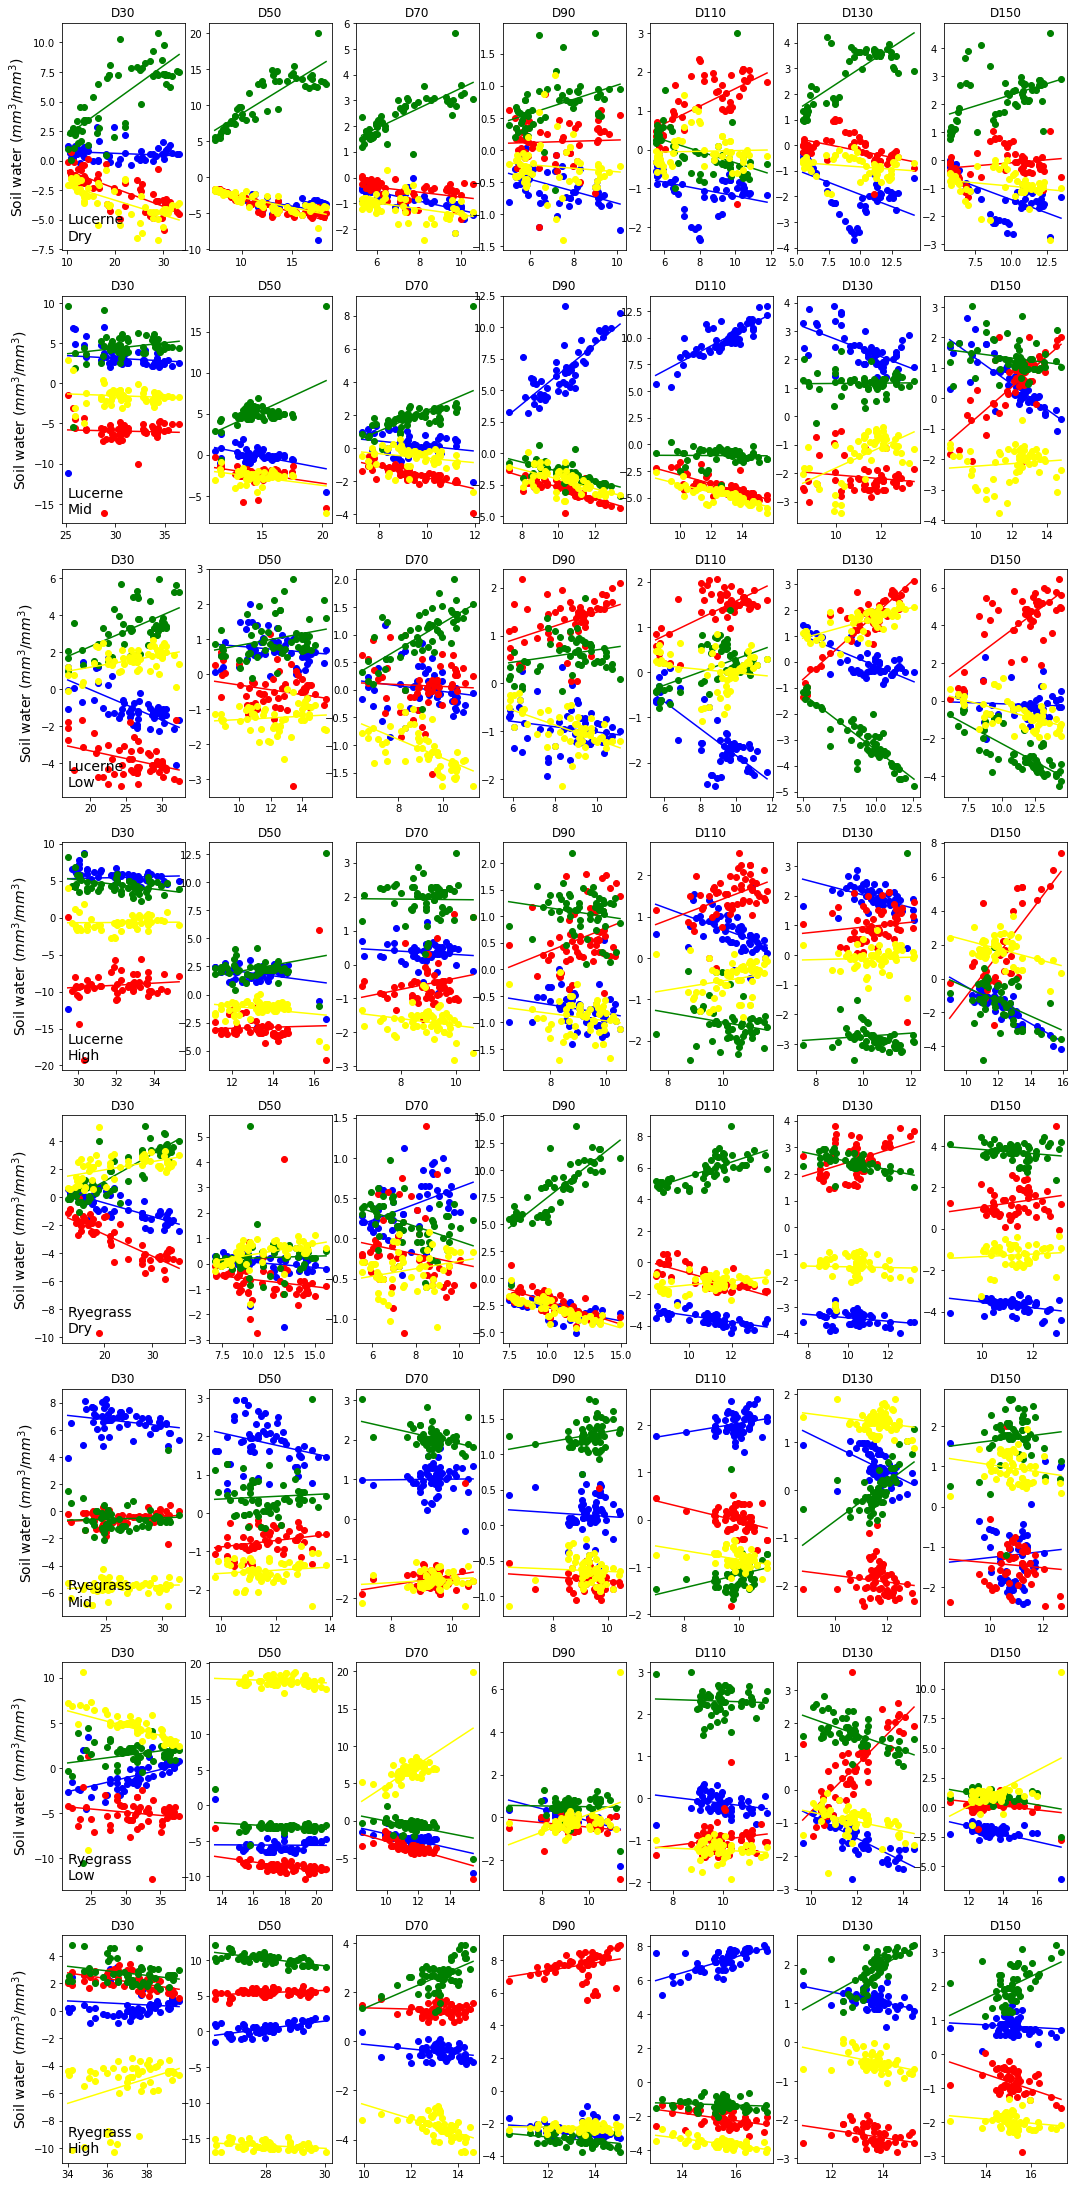

In [81]:
#Create data frame to hold fitted coefficient for each measurement point
SeriesCoefficients = pd.DataFrame(0,index=['Slope','Intercept'],columns=OffSets.columns)                    
#Make a graph
Fig = plt.figure(figsize=(18, 160))

#Function to populate figure with subplots
def MakePlot(Position, TreatmentMeans, SeriesOffSets, Depth, FixedX, FittedY, Col):
    Fig.add_subplot(32,7,Position)
    plt.title(Depth, fontsize=12);
    plt.plot(TreatmentMeans, SeriesOffSets, 'o',color=Col);
    plt.plot(FixedX, FittedY, '-', color=Col)
    return;

def AddPlot(TreatmentMeans, SeriesOffSets, FixedX, FittedY, Col):
    plt.plot(TreatmentMeans, SeriesOffSets, 'o', color=Col);
    plt.plot(FixedX, FittedY, '-', color=Col)
    return;


#Step through each series (plot by depth) data set and fit coefficients and graph the fits
for X in range(0,224):
    #Set up index information for each series
    Depth = AllDataIndex.iloc[X,0]
    Crop = AllDataIndex.iloc[X,1]
    Irrigation = AllDataIndex.iloc[X,2]
    Block = AllDataIndex.iloc[X,3]
    Series = Depth+Crop+Irrigation+Block
    #Create an object containing the time series of mean values for the treatment and depth that the current series belongs to.
    TreatmentMeans = AllTreatmentMeans.loc[:,(Depth,Crop,Irrigation)]
    #Create an object containing the time series of offsets of the measurements for the plot and measurement depth
    # currently under consideration relative to the corresponding treatment mean for that measurement 
    SeriesOffSets = OffSets.loc[:,(Depth,Crop,Irrigation,Block)]

Position = 1
for Cro in Crops:
    for Irr in Irrigs:
        for Dep in Depths:
            bot = 100
            left = 100
            colPos = 0
            for Blo in ['1','2','3','4']:
                #Create an object containing the time series of mean values for the treatment and depth that the current series belongs to.
                TreatmentMeans = AllTreatmentMeans.loc[:,(Dep,Cro,Irr)]
                SeriesOffSets = OffSets.loc[:,(Dep,Cro,Irr,Blo)]

                #Fit linear regression to current series and store slope and intercept in dataframe
                ModVWC = sm.regression.linear_model.OLS(SeriesOffSets,  # Y variable
                                                    sm.add_constant(TreatmentMeans), # X variable
                                                    missing='drop',                                     # ignor and data where one value is missing
                                                    hasconst=False) 
                RegVWC = ModVWC.fit();  # fit models parameters
                Slope = RegVWC.params[1] 
                Intercept = RegVWC.params[0]
                #Draw graph to check fits
                xmin = TreatmentMeans.min()
                xmax = TreatmentMeans.max()
                ymin = Intercept + xmin * Slope
                ymax = Intercept + xmax * Slope
                FixedX = [xmin,xmax]
                FittedY = [ymin, ymax]
                #Assign fitted coeffients to dataframe
                SeriesCoefficients.loc['Slope', (Dep,Cro,Irr,Blo)] = Slope
                SeriesCoefficients.loc['Intercept', (Dep,Cro,Irr,Blo)] = Intercept
                #Add to Graph
                if Blo == '1':
                    MakePlot(Position, TreatmentMeans, SeriesOffSets, Dep, FixedX, FittedY, colors[colPos])
                else:
                    AddPlot(TreatmentMeans, SeriesOffSets, FixedX, FittedY, colors[colPos])
                if Dep == 'D30':
                    left = min(left,TreatmentMeans.min())
                    bot = min(bot,SeriesOffSets.min())
                    if Blo == '4':
                        plt.text(left,bot,Cro+'\n'+Irr,fontsize=14)
                    plt.ylabel(r'Soil water ($mm^3/mm^3$)', fontsize=14)
                colPos +=1
            Position += 1;
                


Next we use the coefficients from the regressions fitted to each plot, along with the treatment mean water contents to calculate synthetic data. 

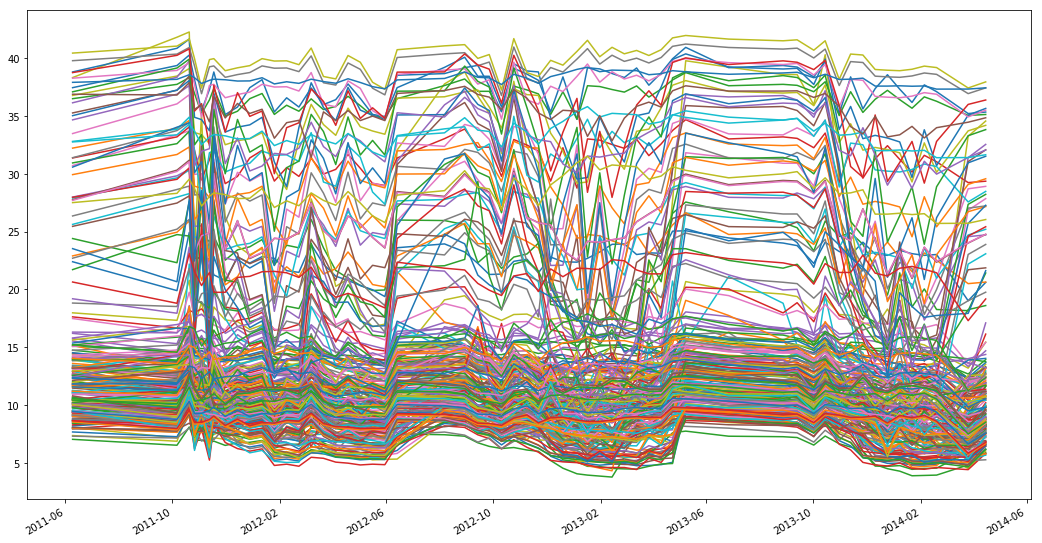

In [82]:
#Set up empty dataframe with the same index and column structure as TDR data
SynthData = pd.DataFrame(index = Data.index, columns = Data.columns)  
#Step through each plot, calculate offset and load the number into the OffSet dataframe
for X in range (0,224): 
    #Setup index data for current series
    Depth = AllDataIndex.iloc[X,0]
    Crop = AllDataIndex.iloc[X,1]
    Irrigation = AllDataIndex.iloc[X,2]
    Block = AllDataIndex.iloc[X,3]
    #Create an object containing the time series of mean values for the treatment and depth that the current series belongs to.
    TreatmentMeans = AllTreatmentMeans.loc[:,(Depth,Crop,Irrigation)]
    #Assign the intercept coefficient for the current series to a variable
    SeriesIntercept = SeriesCoefficients.loc['Intercept',(Depth,Crop,Irrigation,Block)]
    #Assign the slope coefficient for the current series to a variable
    SeriesSlope = SeriesCoefficients.loc['Slope',(Depth,Crop,Irrigation,Block)]
    #Calculate the offset relative to the mean for synthetic data for the current series
    SeriesOffSet = TreatmentMeans * SeriesSlope + SeriesIntercept
    #Apply the offset to the mean to create synthetic data and store in dataframe
    SynthData.loc[:,(Depth,Crop,Irrigation,Block)] = TreatmentMeans + SeriesOffSet

#Plot synthetic Data to make sure it looks OK
SynthData.plot(figsize=(18,10), legend = False)


Finally we substitute the synthetic data in to replace nan values in Data dataframe of measured data

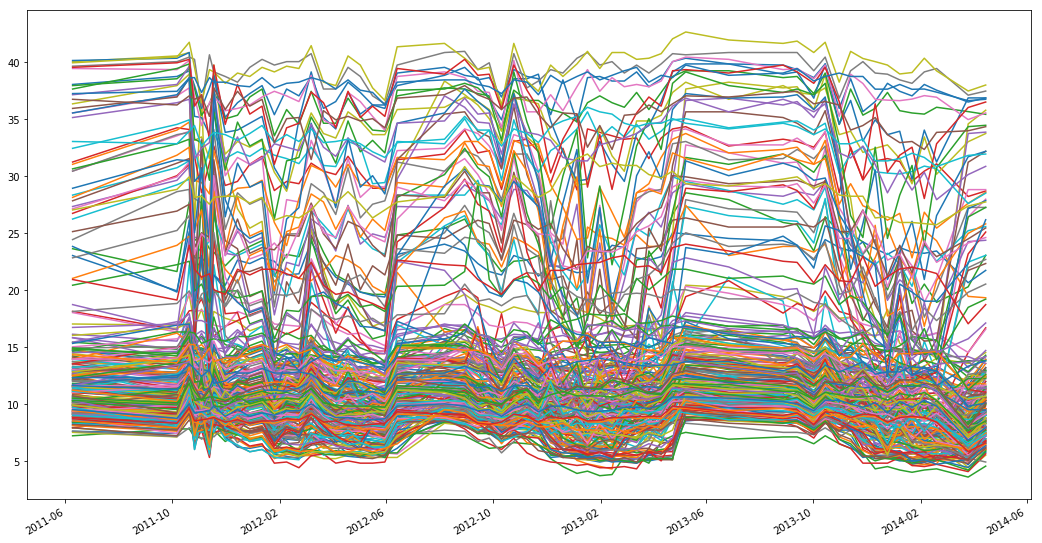

In [83]:
Data.fillna(SynthData, inplace = True)
Data.plot(figsize=(18,10), legend = False)

And check our example from earlier on to see how it looks now

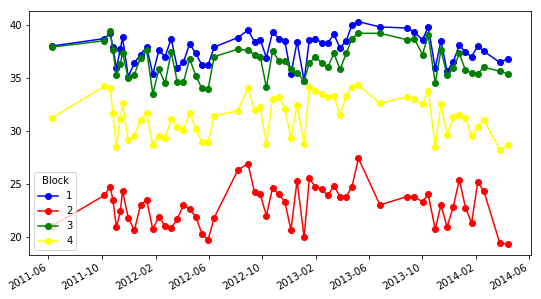

In [84]:
Data.D30.Lucerne.High.plot(marker='o',color=colors,figsize=(9,5))

# Convert data from % to mm^3/mm^3 and export for use in analyses

In [85]:
Data = Data.divide(100)

In [86]:
#Export hourly datafile as pickle
Data.to_pickle('.\DataFrames\\NeutronProbeVWC_df.pkl')